In [1]:
from particle import Particle 
import numpy as np 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt 
import itertools
from math import prod

/home/henry/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from bs4 import BeautifulSoup

with open('DECAY.XML', 'r') as f:
    data = f.read()
Bs_data = BeautifulSoup(data, "xml")
all_decays_unfiltered = Bs_data.find_all('decay')

In [3]:
particles_in_evtgen=[x['name'] for x in all_decays_unfiltered]
all_ids=[]
all_decays=[]
for p in all_decays_unfiltered:
    try:
        all_ids.append(Particle.from_evtgen_name(p['name']).pdgid)
    except:
        None
    else:
        all_decays.append(p)

len(all_decays)

250

In [4]:
def get_decays(pdgid: int):
    assert isinstance(pdgid, int), 'Input of get_decays must be a pdgid in integer form'
    try:
        decay=all_decays[all_ids.index(pdgid)]
        channels=decay.find_all('channel')
    except ValueError:
        channels=[]
    br=[]
    all_daughters=[]
    total_br=0
    for channel in channels:
        branching_ratio=float(channel['br'])
        if branching_ratio>0.01: 
            total_br+=branching_ratio
            br.append(branching_ratio)
            daughters=[int(Particle.from_evtgen_name(x).pdgid) for x in channel['daughters'].split()]
            all_daughters.append(daughters)
    if not all_daughters: return None,None
    else: return [x/total_br for x in br],all_daughters

get_decays(221)

([0.3961902842168918,
  0.3282604313646442,
  0.22918766377746422,
  0.0463616206409998],
 [[22, 22], [111, 111, 111], [-211, 211, 111], [22, -211, 211]])

In [62]:
def check_meson_combinations(m1,m2,m):
    valid=True
    if m1.mass+m2.mass > m: valid=False                                                         #check mass
    if (m1.charge!=0 or m2.charge!=0) and m1.pdgid!=(-1)*m2.pdgid: valid=False                #check if particle-antiparticle pair for charged mesons
    if (m1.charge==0 and m2.charge==0):        
        if m1.C!=m2.C: valid=False                                                         #check charge conjugation eigenvalue
        if m1.J==0 and m2.J==0 and m1.P!=m2.P: valid=False
        if ((m1.J==1 and m2.J==0) or (m1.J==0 and m2.J==1)) and m1.P!=(-1)*m2.P: valid=False    #parity must be opposite for l=1
        if ((m1.J==2 and m2.J==0) or (m1.J==0 and m2.J==2)) and m1.P!=m2.P: valid=False         #parity must be same for l=2
    if m1.I!=m2.I: valid=False                                                                  #isospin conservation
    if ((m1.pdgid.has_up and not m2.pdgid.has_up) or (m1.pdgid.has_down and not m2.pdgid.has_down) or
        (m1.pdgid.has_strange and not m2.pdgid.has_strange) or (m1.pdgid.has_charm and not m2.pdgid.has_charm) or 
        (m1.pdgid.has_bottom and not m2.pdgid.has_bottom)): valid=False
    return valid

def makeMesonPairs(cluster_mass,return_pdgid=True):
    mesons_below_threshold=Particle.findall(lambda p: p.mass<cluster_mass and p.pdgid.is_meson==True)
    if not mesons_below_threshold: print('No possible decay products. Maybe mass is too small?')
    #baryons_below_threshold=Particle.findall(lambda p: p.mass<cluster_mass and p.pdgid.is_baryon==True)
    meson_pairs=[]
    for i,m1 in enumerate(mesons_below_threshold):
        for m2 in mesons_below_threshold[i:]:
            if check_meson_combinations(m1,m2,cluster_mass):
                if return_pdgid: meson_pairs.append((int(m1.pdgid),int(m2.pdgid)))
                else: meson_pairs.append((m1,m2))
    return meson_pairs

from collections import Counter
#takes list of meson pdgids and returns all possible decay products with branching ratios
def decaymesons(mesons):
    all_brs=[]
    all_daughters=[]
    for meson in mesons:
        br,daughters=get_decays(meson)
        if daughters is not None:
            all_daughters.append(daughters)
            all_brs.append(br)
        else:
            all_daughters.append([[meson]])
            all_brs.append([1])
    all_combinations=[tuple(sorted(list(itertools.chain(*x)))) for x in itertools.product(*all_daughters)] #cartesian product to get all combinations
    br_combinations=[prod(x) for x in itertools.product(*all_brs)]
    all_decays=dict.fromkeys(all_combinations,0)
    for s,b in zip(all_combinations,br_combinations):
        all_decays[s]+=b
    if len(all_decays)==1 and next(iter(all_decays))==mesons: return None
    else:
        br_sum=np.sum([x for x in all_decays.values()])
        assert abs(1-br_sum)<1e-3, f'Branching ratios only add up to {br_sum} for state {mesons} with decays {all_decays}'
        return all_decays

def makeinitialWeights(meson_pairs,cluster_mass,spin_supression_par=1,up_weight=1,down_weight=1,strange_weight=1,charm_weight=1,bottom_weight=1):
    weights=np.zeros(len(meson_pairs))
    for i,pair in enumerate(meson_pairs):
        m1=pair[0]
        m2=pair[1]
        p_restframe=np.sqrt((cluster_mass**2-(m1.mass+m2.mass)**2)*(cluster_mass**2-(m1.mass-m2.mass)**2))/2/cluster_mass

        #spin multiplicity
        if m1.J==m2.J: spin_factor=(2*m1.J+1)*spin_supression_par
        else: spin_factor=(2*m1.J+1)*(2*m2.J+1)

        #quark weights
        quark_weight=1
        if m1.pdgid.has_up: quark_weight*=up_weight
        if m1.pdgid.has_down: quark_weight*=down_weight
        if m1.pdgid.has_strange: quark_weight*=strange_weight
        if m1.pdgid.has_charm: quark_weight*=charm_weight
        if m1.pdgid.has_bottom: quark_weight*=bottom_weight


        weights[i]=p_restframe*quark_weight*spin_factor
    return weights/np.sum(weights)
    #return np.ones(len(meson_pairs))/len(meson_pairs)

import networkx as nx 
def simulateDecay(cluster_mass,decay_graph=None,initial_states=None):
    if decay_graph is None:
        decay_graph=nx.DiGraph()
        initial_states=makeMesonPairs(cluster_mass)
        decay_graph.add_nodes_from(initial_states)
    all_decays_finished=True
    states_to_decay= [s for s,d in decay_graph.out_degree() if d==0]
    for state in states_to_decay:
        decays_of_this_state=decaymesons(state)
        if decays_of_this_state is not None: 
            edges=[(state,x,y) for x,y in decays_of_this_state.items()]
            for edge in edges:
                assert not edge in decay_graph.edges().data('weight'), f'Edge {edge} is overwritten'
            decay_graph.add_weighted_edges_from(edges)
            all_decays_finished=False

    if not all_decays_finished: decay_graph,initial_states=simulateDecay(cluster_mass,decay_graph,initial_states)
    return decay_graph,initial_states




In [86]:
pairs=makeMesonPairs(2000,return_pdgid=False)
w=makeinitialWeights(pairs,2000,1)
w

array([0.01651032, 0.02295677, 0.03057356, 0.00943428, 0.00212099,
       0.01449253, 0.0315748 , 0.01445333, 0.01445333, 0.01445333,
       0.01445333, 0.02238244, 0.02238244, 0.01387641, 0.01387641,
       0.01649972, 0.0315748 , 0.01393959, 0.01877311, 0.00602509,
       0.00311397, 0.03111527, 0.01104497, 0.0272466 , 0.01445333,
       0.01445333, 0.01445333, 0.02238244, 0.02238244, 0.01387641,
       0.01387641, 0.01445333, 0.01445333, 0.02238244, 0.02238244,
       0.01387641, 0.01387641, 0.01445333, 0.02238244, 0.02238244,
       0.01387641, 0.01387641, 0.0222429 , 0.0222429 , 0.02461474,
       0.02461474, 0.0222429 , 0.02461474, 0.02461474, 0.01449073,
       0.02262906, 0.00479059, 0.00343236, 0.00331586, 0.00331586,
       0.01333025, 0.00991378, 0.00891071, 0.00891071, 0.00891071,
       0.00891071, 0.00235058])

In [50]:
pairs

[(<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
  <Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>),
 (<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
  <Particle: name="pi(2)(1670)0", pdgid=10115, mass=1670.6 + 2.9 - 1.2 MeV>),
 (<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
  <Particle: name="a(1)(1260)0", pdgid=20113, mass=1230 ± 40 MeV>),
 (<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
  <Particle: name="pi(1300)0", pdgid=100111, mass=1300 ± 100 MeV>),
 (<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
  <Particle: name="pi(1800)0", pdgid=9010111, mass=1810 + 9 - 11 MeV>),
 (<Particle: name="pi0", pdgid=111, mass=134.9768 ± 0.0005 MeV>,
  <Particle: name="a(1)(1640)0", pdgid=9020113, mass=1655 ± 16 MeV>),
 (<Particle: name="rho(770)0", pdgid=113, mass=775.26 ± 0.23 MeV>,
  <Particle: name="rho(770)0", pdgid=113, mass=775.26 ± 0.23 MeV>),
 (<Particle: name="K(L)0", pdgid=130, mass=497.611 ± 

In [31]:
pairs[0][0].quarks
(pairs[0][0].pdgid.has_anti_charm)

AttributeError: 'PDGID' object has no attribute 'has_anti_charm'

In [60]:
decay_graph,initial_states=simulateDecay(2000)

In [65]:
def buildWeights(decay_graph,cluster_mass,initial_states):
    nx.set_node_attributes(decay_graph,0,name='weight')
    initial_states=makeMesonPairs(cluster_mass,return_pdgid=False)
    init_weights=makeinitialWeights(initial_states,cluster_mass)
    for s,w in zip(initial_states,init_weights):
        decay_graph.nodes[s]['weight']=w
    has_weight=[]
    while len(has_weight)!=len(decay_graph.nodes):
        for node in decay_graph.nodes:
            in_edges=decay_graph.in_edges(node,'weight')
            in_weights=[decay_graph.nodes[x[0]]['weight'] for x in in_edges]
            if not 0 in in_weights and not node in has_weight:
                for edge in in_edges:
                    decay_graph.nodes[node]['weight']+=decay_graph.nodes[edge[0]]['weight']*edge[2]
                has_weight.append(node)
    return decay_graph
weighted_graph=buildWeights(decay_graph,2000,initial_states)
print(weighted_graph)

DiGraph with 1053 nodes and 2769 edges


In [66]:
def brs_consistency_check(decay_graph):
    for node in decay_graph.nodes:
        decays=decaymesons(node)
        br=0
        out_edges=decay_graph.out_edges(node,'weight')
        for edge in out_edges:
            br+=edge[2]
        for d in out_edges:
            assert d[1] in decays.keys(), f'Decay {d} is missing from outgoing edges for node {node}.\n Decays: {decays} \n outgoing edges: {out_edges}'
        if out_edges: assert br>0.99, f'Branching ratio of state {node} is only {br}, with edges {out_edges}'

def weight_consistency_check(decay_graph,initial_states):
    for node in decay_graph.nodes:
        w=0
        edges=decay_graph.in_edges(node,'weight')
        for edge in edges:
            w+=decay_graph.nodes[edge[0]]['weight']*edge[2]
        if node in initial_states: w+=1/len(initial_states)
        weight=decay_graph.nodes[node]['weight'] 
        assert abs(weight-w)<1e-5,f'Wrong weight of node {node}: Is {weight}, should be {w}'
    assert not 0 in [v for u,v in decay_graph.nodes.data('weight')]

def total_brs_consistency_check(decay_graph):
    final_states,brs=get_final_states(decay_graph)
    assert abs(np.sum(brs)-1)<1e-5

weight_consistency_check(weighted_graph,initial_states)
brs_consistency_check(weighted_graph)
total_brs_consistency_check(weighted_graph)

AssertionError: Wrong weight of node (111, 111): Is 0.01651032436232279, should be 0.016129032258064516

In [89]:
def get_final_states(decay_graph):
    final_states= [s for s,d in decay_graph.out_degree() if d==0]
    attributes=nx.get_node_attributes(decay_graph,'weight')
    return {f:attributes[f] for f in final_states}

def most_common_final_states(decay_graph):
    final_states=get_final_states(decay_graph)
    return {k: v for k, v in sorted(final_states.items(), key=lambda item: item[1],reverse=True)}
    
final_states=get_final_states(weighted_graph)
sorted_final_states=most_common_final_states(weighted_graph)
for k in sorted_final_states.items():
    print(k)

((-211, 22, 22, 22, 22, 211), 0.08194914577891158)
((-211, -211, 22, 22, 22, 22, 211, 211), 0.0530388472820452)
((-211, -211, 211, 211), 0.051721678234780015)
((-211, 130, 211), 0.04508019499808974)
((-211, 22, 22, 130, 321), 0.04331288479171047)
((-321, 22, 22, 130, 211), 0.04331288479171047)
((-211, -211, 130, 211, 211), 0.04279590930963165)
((130, 130), 0.03974664730239598)
((-211, 130, 130, 211), 0.030872144469904227)
((-211, -211, 22, 22, 211, 321), 0.0300208217037136)
((-321, -211, 22, 22, 211, 211), 0.0300208217037136)
((-211, 22, 22, 22, 22, 130, 211), 0.028593300157240677)
((-211, 211, 9000221), 0.0239128210643324)
((22, 22, 10115), 0.022687288703577627)
((22, 22, 22, 22, 130), 0.019493922509122307)
((22, 22, 22, 22), 0.0183154314320326)
((-211, 211), 0.016499716701140747)
((-211, 321, 9000311), 0.016418871976381685)
((-9000311, -211, 321), 0.016418871976381685)
((-321, 211, 9000311), 0.016418871976381685)
((-9000311, -321, 211), 0.016418871976381685)
((-211, -211, -211, 211, 

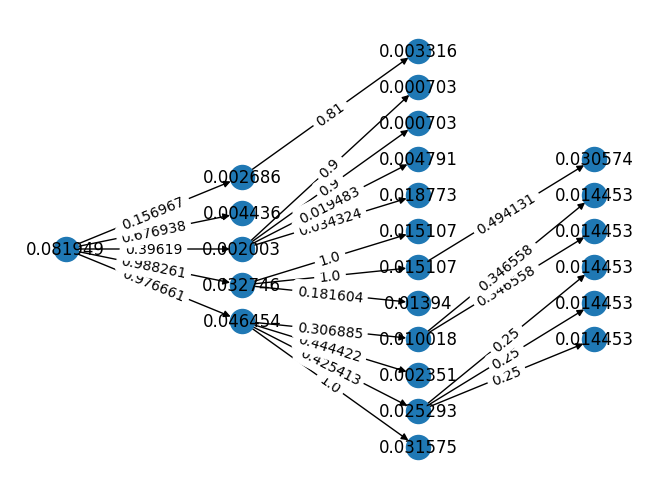

In [91]:
def plot_from_initial_state(decay_graph,state):
    round_val=4
    edge_data = { (u,v) : d for u, v, d in decay_graph.edges.data() }  
    node_data = { u : d for u, d in decay_graph.nodes.data() }  
    sub = nx.dfs_tree(decay_graph,state)
    nx.set_edge_attributes(sub, edge_data)
    nx.set_node_attributes(sub,node_data)
    pos=nx.bfs_layout(sub,state)
    edge_labels = {key:round(val,round_val) for key,val in nx.get_edge_attributes(sub,'weight').items()}

    nx.draw(sub,with_labels=False,pos=pos)
    nx.draw_networkx_edge_labels(sub,pos,edge_labels=edge_labels)
    plt.show()

def plot_from_final_state(decay_graph,state):
    round_val=6
    decay_graph=decay_graph.reverse()
    edge_data = { (u,v) : d for u, v, d in decay_graph.edges.data() }  
    node_data = { u : d for u, d in decay_graph.nodes.data() }  
    sub = nx.dfs_tree(decay_graph,state)
    nx.set_edge_attributes(sub, edge_data)
    nx.set_node_attributes(sub,node_data)
    pos=nx.bfs_layout(sub,state)
    edge_labels = {key:round(val,round_val) for key,val in nx.get_edge_attributes(sub,'weight').items()}
    node_labels = {key:round(val,round_val) for key,val in nx.get_node_attributes(sub,'weight').items()}

    nx.draw(sub,with_labels=False,pos=pos)
    nx.draw_networkx_edge_labels(sub,pos,edge_labels=edge_labels)
    nx.draw_networkx_labels(sub,pos,labels=node_labels)
    plt.show()

final_states=list(get_final_states(decay_graph).keys())
plot_from_final_state(weighted_graph,(-211,22,22,22,22,211))